<a href="https://colab.research.google.com/github/rkspatel08/General_Notes/blob/main/PSL_Coding_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data1.csv"
myData = pd.read_csv(url)
# myData.head()
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [6]:
X.shape, len(Y)

((506, 91), 506)

**Conduct the following simulation exercise 50 times:**


a. In each iteration, randomly split the data into two parts, 75% for training and 25% for testing.

b. For each of the six procedures, train a model using the training subset and generate predictions for the test subset. Record the MSPE (Mean Squared Prediction Error) based on these test data predictions.

In [42]:
# randomly split the data into two parts, 75% for training and 25% for testing.
def split_train_test(X, Y):
  # Splitting the data into training and testing sets
  n = len(Y)
  indices = np.arange(0, n)
  np.random.shuffle(indices)
  test_ind = indices[:int(np.floor(0.25*n))]
  train_ind = indices[len(test_ind):]

  # Splitting the data into training and testing sets
  X_train1 = X.iloc[train_ind]
  Y_train = Y[train_ind]
  X_test1 = X.iloc[test_ind]
  Y_test = Y[test_ind]
  scaler = StandardScaler(with_mean=True, with_std=True)
  X_train = scaler.fit_transform(X_train1)
  X_test = scaler.transform(X_test1)
  return X_train, Y_train, X_test, Y_test

In [40]:
split_train_test(X, Y)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


(array([[-0.57496449,  0.50904529, -0.53695797, ...,  0.13561317,
         -0.4913875 , -0.57307578],
        [-0.20919268, -0.46802246, -0.23744667, ...,  0.48504264,
         -0.28272136, -0.52248648],
        [-1.48568301,  3.30701202, -3.22429786, ..., -0.66629812,
         -0.92951548, -0.59444485],
        ...,
        [-0.74271605, -0.46802246,  1.38043403, ...,  0.068882  ,
          0.12205357,  0.88997465],
        [-1.30868833, -0.46802246, -1.82114407, ..., -0.1030123 ,
         -0.65969282, -0.71973683],
        [-0.38012541, -0.46802246, -0.04481506, ...,  1.77085156,
          1.28324167,  0.55332252]]),
 250    3.194583
 326    3.135494
 56     3.206803
 396    2.525729
 302    3.273364
          ...   
 312    2.965273
 317    2.985682
 124    2.933857
 5      3.356897
 103    2.960105
 Name: Y, Length: 380, dtype: float64,
 array([[ 8.64856410e-01, -4.68022464e-01,  1.02973982e+00, ...,
         -1.26598495e+00, -1.14874377e+00, -1.06304941e+00],
        [ 1.24641365e

**PCR Implemenation (as given in sample code)**

In [34]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

Run simulations,split the train and test data and train below models:

**Full**: Fit a linear regression model using all features

**Ridge.min** : Ridge regression using lambda.min

**Lasso.min and Lasso.1se:** Lasso using lambda.min or lambda.1se

**L.Refit:** Refit the model selected by Lasso using lambda.1se

**PCR**: principle components regression with the number of components chosen by 10-fold cross validation

In [28]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [45]:
# run simulation 50 times and train given models
sims = 50
full_mse_list, ridge_mse_list, lasso_min_list,lasso_1se_list ,refit_mse_list, pcr_mse_list = [], [], [],[], [], []

for i in range(sims):
  X_train, Y_train, X_test, Y_test = split_train_test(X, Y)

  #Full: Fit a linear regression model using all features
  full_molel = lm().fit(X_train, Y_train)
  full_mse = mean_squared_error(Y_test, full_molel.predict(X_test))
  full_mse_list.append(full_mse)

  #Ridge.min : Ridge regression using lambda.min
  ridge_alphas = np.logspace(-10, 1, 100)
  ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10,
                  scoring = 'neg_mean_squared_error')
  ridgecv.fit(X_train, Y_train)
  ridge_model = Ridge(alpha = ridgecv.alpha_)
  ridge_model.fit(X_train, Y_train)
  ridge_model_mse = mean_squared_error(Y_test, ridge_model.predict(X_test))
  ridge_mse_list.append(ridge_model_mse)

  lasso_alphas = np.logspace(-10, 1, 100)
  lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
  lassocv.fit(X_train, Y_train)
  mean_mse = np.mean(lassocv.mse_path_, axis=1)
  std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10)
  cv_alphas = lassocv.alphas_
  min_idx = np.argmin(mean_mse)
  alpha_min = cv_alphas[min_idx]
  threshold = mean_mse[min_idx] + std_mse[min_idx]
  alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

  #lasso using lambda min
  lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
  lasso_model_min.fit(X_train, Y_train)
  lasso_min_mse = mean_squared_error(Y_test, lasso_model_min.predict(X_test))
  lasso_min_list.append(lasso_min_mse)

  #lasso using lambda_1se
  lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
  lasso_model_1se.fit(X_train, Y_train)
  lasso_1se_mse = mean_squared_error(Y_test, lasso_model_1se.predict(X_test))
  lasso_1se_list.append(lasso_1se_mse)

  #Refit the model selected by Lasso using lambda.1se
  nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
  lm_refit = lm()
  lm_refit.fit(X_train[:, nonzero_indices], Y_train)
  lasso_1se_refit_mse = mean_squared_error(Y_test, lm_refit.predict(X_test[:, nonzero_indices]))
  refit_mse_list.append(lasso_1se_refit_mse)

  # pcr training and mse capturing
  pcr = PCR()
  pcr.fit(X_train,  Y_train.to_numpy())
  pcr_mse = mean_squared_error(Y_test, pcr.predict(X_test))
  pcr_mse_list.append(pcr_mse)



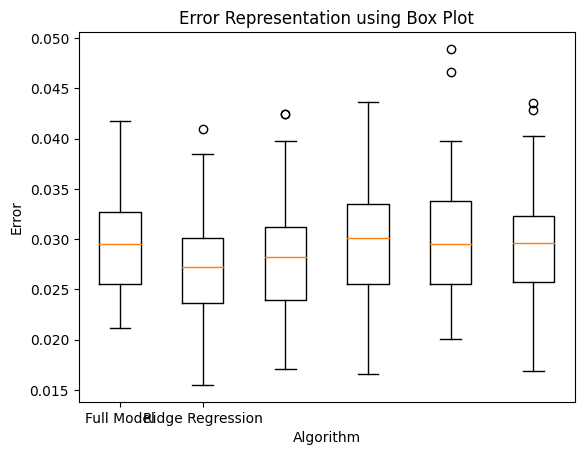

In [46]:
# plot the errors
plot_data = [full_mse_list,ridge_mse_list, lasso_min_list,lasso_1se_list, refit_mse_list, pcr_mse_list ]
methods = ['Full Model', 'Ridge Regression']
plt.boxplot(plot_data)
plt.title('Error Representation using Box Plot')
plt.xlabel('Algorithm')
plt.ylabel('Error')
plt.xticks(range(1, len(methods) + 1), methods)
plt.show()

In [8]:
full = lm().fit(X_train, Y_train)
mean_squared_error(Y_test, full.predict(X_test))

0.021598535596213147